# Proyecto # 1 - 1a Parte
## Product Development - Ing. Preng Biba
### Hugo Brian Bay Rojas - Carnet 20002544

## 2. Feature Engineering

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

In [63]:
data = pd.read_csv('Engineering_graduate_salary.csv')
print(data.shape)

(2998, 34)


In [64]:
data.head()

,ID,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,...,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Salary
0,604399,f,1990-10-22,87.80,cbse,2009,84.00,cbse,6920,1,...,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889,445000
1,988334,m,1990-05-15,57.00,cbse,2010,64.50,cbse,6624,2,...,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859,110000
2,301647,m,1989-08-21,77.33,"maharashtra state board,pune",2007,85.17,amravati divisional board,9084,2,...,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875,255000
3,582313,m,1991-05-04,84.30,cbse,2009,86.00,cbse,8195,1,...,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805,420000
4,339001,f,1990-10-30,82.00,cbse,2008,75.00,cbse,4889,2,...,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864,200000


In [65]:
#separamos data para entrenamiento y prueba,
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['ID', 'CollegeCityID', 'Salary'], axis=1),
                        data['Salary'],
                        test_size=0.15,
                        random_state=2021)

In [66]:
X_train.shape, X_test.shape

((2548, 31), (450, 31))

### 2.1. Transformación del Target a Gausssiano

In [67]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### 2.2. Variables temporales

In [68]:
temp_vars = ['DOB', '12graduation', 'GraduationYear']

#### 2.2.1. Variables temporales con valor cero

In [69]:
for var in temp_vars:
    mode = X_train[var].mode()[0]
    
    X_train[var] = np.where(X_train[var] == 0, mode, X_train[var])
    X_test[var] = np.where(X_test[var] == 0, mode, X_test[var])
    
    print(var, "-------", mode)

DOB ------- 1991-07-03
12graduation ------- 2009
GraduationYear ------- 2013


#### 2.2.2. Cálculo de edades de graduación de Highscool y Bachelor degree

In [70]:
# Extracción del año de la variable 'DOB'
X_train['YOB'] = X_train['DOB'].str[0:4].astype('int')
X_test['YOB'] = X_test['DOB'].str[0:4].astype('int')

In [71]:
def elapsed_time(df, var, ref):
    df[var] = df[var] - df[ref]
    return df

In [72]:
year_vars = ['YOB', '12graduation', 'GraduationYear']

In [73]:
ref = 'YOB'

for var in year_vars:
    if(var is not ref):
        X_train = elapsed_time(X_train, var, ref)
        X_test = elapsed_time(X_test, var, ref)

In [74]:
#Eliminamos columnas DOB y YOB debido a que ya no son necesarias
X_train.drop(['DOB', 'YOB'], axis=1, inplace=True)
X_test.drop(['DOB', 'YOB'], axis=1, inplace=True)

### 2.3. Transformación de variables numéricas

In [75]:
yj_vars = ['10percentage', '12percentage', 'collegeGPA', 'English', 'Logical', 'Quant', 'Domain', 'conscientiousness', 'agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience']

#### 2.3.1. Transformación Yeo Johnson

In [76]:
for var in yj_vars:
    X_train[var], param = stats.yeojohnson(X_train[var])
    X_test[var] = stats.yeojohnson(X_test[var], lmbda=param)
    print(var, '-------', param)

10percentage ------- 2.7627486367336602
12percentage ------- 1.0082210694289289
collegeGPA ------- 1.9574391101583088
English ------- 0.5928861789478358
Logical ------- 1.4081907155406113
Quant ------- 1.0819095871004578
Domain ------- 2.8783564187266664
conscientiousness ------- 1.2951067007478405
agreeableness ------- 1.5346356847230902
extraversion ------- 1.2561539894830207
nueroticism ------- 0.8952021703890255
openess_to_experience ------- 1.535431134261329


#### 2.3.2. Binarización de variables con sesgo fuerte

In [77]:
sesgadas = ['ElectronicsAndSemicon', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg']

In [78]:
for var in sesgadas:
    X_train[var] = np.where(X_train[var] == -1, -1, 0)
    X_test[var] = np.where(X_test[var] == -1, -1, 0)

### 2.4. Codificación de variables categóricas

In [79]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['CollegeID']
cat_vars = [var for var in cat_vars if var not in temp_vars]
len(cat_vars)

7

In [80]:
rare_lab_vars = ['10board', '12board', 'Specialization', 'CollegeState', 'CollegeID']
no_rare_lab_vars = ['Gender', 'Degree']

In [81]:
#funcion para encontar etiquetas raras
def find_rare_labels_freq(df, var, rare_perc):
    temp = df.groupby(var)[var].count()/len(df)
    return temp[temp > rare_perc].index

In [82]:
for var in rare_lab_vars:
    freqValue = find_rare_labels_freq(X_train, var, 0.01)
    
    #print(var, '--------', freqValue)
    
    X_train[var] = np.where(X_train[var].isin(freqValue), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(freqValue), X_test[var], 'Rare')

In [83]:
def replace_category_vals(train, test, y_train, var, target):
    
    temp = pd.concat([train, y_train], axis=1) 
    order_labels = temp.groupby([var])[target].mean().sort_values().index
    
    ordinal_values = {k: i for i, k in enumerate(order_labels, 0)}
    
    print(var, ordinal_values)
    
    train[var] = train[var].map(ordinal_values)
    test[var] = test[var].map(ordinal_values)

In [84]:
for var in cat_vars:
    replace_category_vals(X_train, X_test, y_train, var, 'Salary')

Gender {'f': 0, 'm': 1}
10board {'state board': 0, 'up board': 1, 'matriculation': 2, 'cbse': 3, 'Rare': 4, 'icse': 5, 'ssc': 6, '0': 7}
12board {'state board': 0, 'up board': 1, 'icse': 2, 'cbse': 3, 'Rare': 4, '0': 5}
Degree {'MCA': 0, 'B.Tech/B.E.': 1, 'M.Tech./M.E.': 2, 'M.Sc. (Tech.)': 3}
Specialization {'computer application': 0, 'electrical engineering': 1, 'electronics and electrical engineering': 2, 'computer science & engineering': 3, 'Rare': 4, 'information technology': 5, 'electronics and communication engineering': 6, 'electronics & telecommunications': 7, 'mechanical engineering': 8, 'computer engineering': 9}
CollegeState {'West Bengal': 0, 'Tamil Nadu': 1, 'Telangana': 2, 'Uttar Pradesh': 3, 'Maharashtra': 4, 'Rajasthan': 5, 'Haryana': 6, 'Punjab': 7, 'Madhya Pradesh': 8, 'Orissa': 9, 'Uttarakhand': 10, 'Rare': 11, 'Andhra Pradesh': 12, 'Karnataka': 13, 'Delhi': 14}
CollegeID {'272': 0, 'Rare': 1}


In [85]:
def analyse_other_cats(train, y_train, var):
    temp = pd.concat([train, y_train], axis=1)

    sns.catplot(x=var, y='Salary', data=temp, kind='box', height=4, aspect=1.5)
    sns.stripplot(x=var, y='Salary', data=temp, jitter=0.1, alpha=0.3, color='k')
    plt.show()

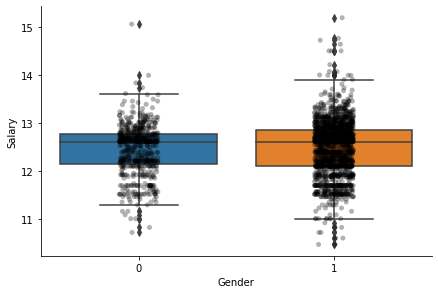

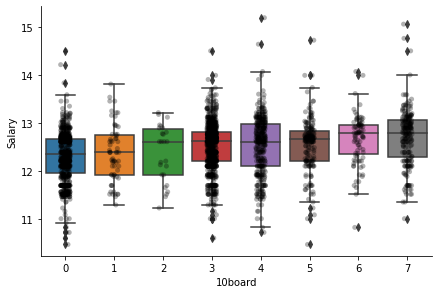

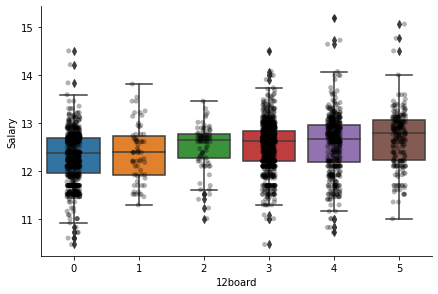

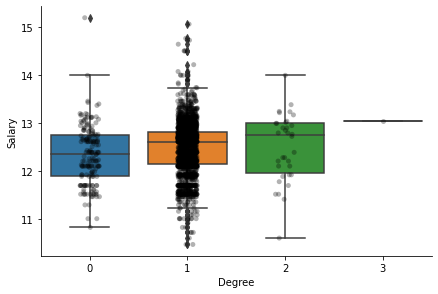

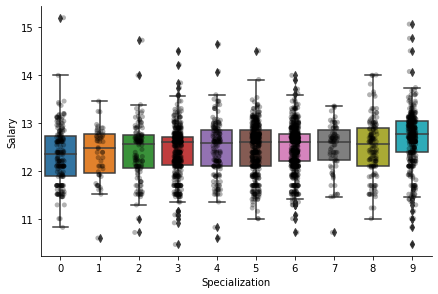

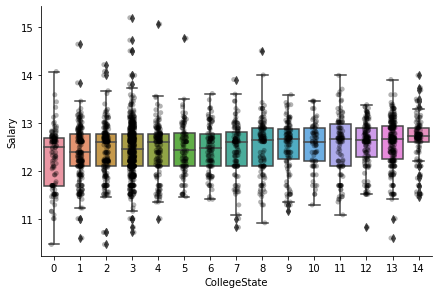

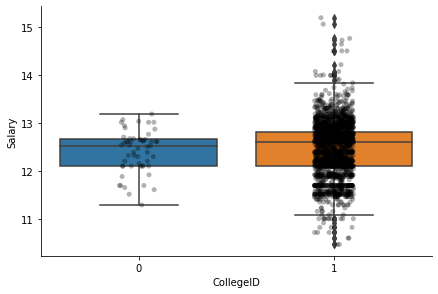

In [86]:
for var in cat_vars:
    analyse_other_cats(X_train, y_train, var)

### 2.5. Feature Scaling

In [87]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [88]:
X_train.head()

,Gender,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,Degree,Specialization,...,ComputerScience,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience
0,1.0,0.855113,1.000000,0.416667,0.868458,1.0,1.0,1.0,0.333333,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.585457,0.539635,0.396886,0.414635,0.524328
1,1.0,0.394038,0.000000,0.333333,0.527235,0.0,1.0,1.0,0.333333,0.888889,...,0.0,1.0,0.0,0.0,0.0,0.754359,0.717695,0.685098,0.216616,0.753647
2,1.0,0.365950,0.857143,0.333333,0.459077,0.8,1.0,1.0,0.333333,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.648617,0.598761,0.778138,0.553544,0.653226
3,1.0,0.080658,0.000000,0.416667,0.438637,0.0,1.0,1.0,0.333333,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.292688,0.487611,0.867842,0.652266,0.473856
4,0.0,0.050823,0.428571,0.333333,0.339883,0.6,1.0,1.0,0.333333,0.666667,...,0.0,0.0,0.0,1.0,0.0,0.492523,0.802067,0.602628,0.551051,0.894433


In [91]:
#Guardamos dataset con data preparada para entrenamiento.

X_train.to_csv('preprocess_data/prep_Xtrain.csv', index=False)
X_test.to_csv('preprocess_data/prep_Xtest.csv', index=False)

y_train.to_csv('preprocess_data/prep_ytrain.csv', index=False)
y_test.to_csv('preprocess_data/prep_ytest.csv', index=False)

In [90]:
joblib.dump(scaler, 'preprocess_data/minmax_scaler.joblib')

['preprocess_data/minmax_scaler.joblib']